In [2]:
import numpy as np
import pandas as pd


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from math import sqrt
from scipy import stats
from scipy.stats import norm


import matplotlib.pyplot as plt
import matplotlib as matplotlib
import seaborn as sns
%matplotlib inline


def data_process(test=False):
    
    
    # Read file for train or test.
    
    df_raw_train = pd.read_csv('train.csv',index_col=0)
    df_raw_test = pd.read_csv('test.csv',index_col=0)
    
#     print(df_raw_train.shape)
#     print(df_raw_test.shape)
        
    # Remove outliers in training set.   
    outlier_list_scatter = [524, 1299]
    outlier_list_hard_to_fit = [
        463, 31, 534, 1433, 739, 1159, 108, 1231, 971, 1424 
    ]
    outlier_list = outlier_list_scatter + outlier_list_hard_to_fit
    df_raw_train = df_raw_train.drop(outlier_list)
    
    # Store the sale price information
    sale_price_train = df_raw_train['SalePrice']
    
    # Drop the sales price column to only keep the features
    df_raw_train = df_raw_train.drop(['SalePrice'], axis = 1)
#     print(df_raw_train.shape)
    
    # Merge train and test df together for later process
    df_processed = pd.concat([df_raw_train, df_raw_test], sort=True)
    

    # Combine bathroom quanlitity 
    df_processed['BsmtBath'] = df_processed.BsmtFullBath + df_processed.BsmtHalfBath * 0.5
    df_processed['Bath'] = df_processed.FullBath + df_processed.HalfBath * 0.5
       
    
    ## Drop multicollinear columns 
    df_processed = df_processed.drop(['BsmtFullBath', 'BsmtHalfBath','FullBath','HalfBath'], axis=1)
    
    
    ## Missing values
    
    # 259 LotFrontage  - replace missing value with 0 
#     df_processed.LotFrontage = df_processed.LotFrontage.fillna(0)
    df_processed["LotFrontage"] = df_processed.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

    # 1369 Alley - replace with None
    df_processed.Alley = df_processed.Alley.fillna('None')

    # 8 MasVnrType and MasVnrArea - replace MasVnrType with None and MasVnrArea with 0
    df_processed.MasVnrType = df_processed.MasVnrType.fillna('None')
    df_processed.MasVnrArea = df_processed.MasVnrArea.fillna(0)

    # 37 basement: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2- replace with None
    df_processed.BsmtQual = df_processed.BsmtQual.fillna('None')
    df_processed.BsmtCond = df_processed.BsmtCond.fillna('None')
    df_processed.BsmtExposure = df_processed.BsmtExposure.fillna('None')
    df_processed.BsmtFinType1 = df_processed.BsmtFinType1.fillna('None')
    df_processed.BsmtFinType2 = df_processed.BsmtFinType2.fillna('None')
    df_processed.TotalBsmtSF = df_processed.TotalBsmtSF.fillna(0)
    

    # 690 FireplaceQu - replace with None
    df_processed.FireplaceQu = df_processed.FireplaceQu.fillna('None')

    # 81 Garage: GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond - replace with None and year with 0 
    df_processed.GarageType = df_processed.GarageType.fillna('None')
    df_processed.GarageFinish = df_processed.GarageFinish.fillna('None')
    df_processed.GarageQual = df_processed.GarageQual.fillna('None')
    df_processed.GarageCond = df_processed.GarageCond.fillna('None')
    df_processed.GarageYrBlt = df_processed.GarageYrBlt.fillna(0)

    # 1453 PoolQC - replace with None
    df_processed.PoolQC = df_processed.PoolQC.fillna('None')

    # 1179 Fence - replace with None
    df_processed.Fence = df_processed.Fence.fillna('None')

    # 1406 MiscFeature - replace with None    
    df_processed.MiscFeature = df_processed.MiscFeature.fillna('None')

    # 1 Electrical
    df_processed = df_processed[pd.notnull(df_processed.Electrical)]
    
    #Missing Value only in test data 
    
    # MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
    df_processed['MSZoning'] = df_processed['MSZoning'].fillna(df_processed['MSZoning'].mode()[0])

    # Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
    df_processed.drop(['Utilities'], axis=1,inplace=True)

    # Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
    df_processed['Exterior1st'] = df_processed['Exterior1st'].fillna(df_processed['Exterior1st'].mode()[0])
    df_processed['Exterior2nd'] = df_processed['Exterior2nd'].fillna(df_processed['Exterior2nd'].mode()[0]) 
    
    # BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtBath : missing values are likely zero for having no basement
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtBath'):
        df_processed[col] = df_processed[col].fillna(0)    
    
    #Garage Cars 
    df_processed.GarageCars = df_processed.GarageCars.fillna(0) 
    
    # SaleType : Fill in again with most frequent which is "WD"
    df_processed['SaleType'] = df_processed['SaleType'].fillna(df_processed['SaleType'].mode()[0])
    
    # KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
    df_processed['KitchenQual'] = df_processed['KitchenQual'].fillna(df_processed['KitchenQual'].mode()[0])    
    
    # Functional : data description says NA means typical
    df_processed["Functional"] = df_processed["Functional"].fillna("Typ")    
    

    # drop GarageArea - higher correlation than GarageACars, results are better as well
    df_processed = df_processed.drop(['GarageArea'], axis=1) 
    df_processed = df_processed.drop(['MiscFeature'], axis=1) 
#     df_processed = df_processed.drop(['1stFlrSF'], axis=1) 
    df_processed = df_processed.drop(['TotRmsAbvGrd'], axis=1) 

    
    # Feature Transformation - take the logarithm of the features.
    #Linear_Num_Cols = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'LotArea', 'GarageArea', 'TotRmsAbvGrd', 'TotalSF', 'BsmtFinSF1']
    df_processed.GrLivArea = np.log(df_processed.GrLivArea)
    df_processed.TotalBsmtSF = np.log(df_processed.TotalBsmtSF+1)
#     df_processed.LotArea = np.log(df_processed.LotArea) -- performance decreases
#     df_processed.GarageArea = np.log(df_processed.GarageArea) -- will drop column 



    # Categorical Features Processsing

    # MSSubClass processing - MSSubClass 20-90 contains only duplicate information with HouseStyle and YearBuilt.
    df_processed['MSSubClass'] = df_processed['MSSubClass'].replace(['20','30','40','45','50','60','70','75','80','85'], '0')

    # Convert numerical to categorical. 
    df_processed['MSSubClass'] = df_processed['MSSubClass'].astype(str)

    #Encode some categorical features as ordered numbers when there is information in the order.
    df_processed = df_processed.replace({"Alley" : {"None":0,"Grvl" : 1, "Pave" : 2},
#                        "Neighborhood" : {"SWISU" : 1, "IDOTRR" : 2, "OldTown" : 3, "BrDale" : 4, "Blueste": 5,
#                        "Edwards" : 6, "MeadowV" : 7, "BrkSide" : 8, "NWAmes" : 9, "NAmes" : 10, "NPkVill" : 11, "Sawyer" : 12, "Gilbert": 13, 
#                        "SawyerW" : 14, "Crawfor" : 15, "ClearCr" : 16, "Mitchel" : 17, "NoRidge": 18, "Blmngtn" : 19, "CollgCr" : 20, "Timber" : 21, "Somerst" : 22, "Veenker": 23, "NridgHt" : 24, "StoneBr": 25 },
                       "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"None" : 0,"No":1, "Mn" : 2, "Av": 3, "Gd" : 4},
                       "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5,
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 3, "Mod" : 2, "Gtl" : 1},
                       "LotShape" : {"IR3" : 4, "IR2" : 3, "IR1" : 2, "Reg" : 1},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2}})
    

    
    # Year processing 
    # Combine year sold with year build to year old
    df_processed['YearsOld']  = df_processed['YrSold'] - df_processed['YearBuilt']
    df_processed = df_processed.drop(['YearBuilt'], axis=1)

    # Combine YrSold and YearRemodAdd
    df_processed['YearSinceRemodel'] = df_processed['YrSold'] - df_processed['YearRemodAdd']
    df_processed = df_processed.drop(['YearRemodAdd'], axis=1)
    df_processed = df_processed.drop(['YrSold'], axis=1)
    
    # Missing rate greater than 47%, and low correlation with sale price
    df_processed = df_processed.drop(['FireplaceQu'], axis=1)

    # PoolQC has .99 missing value. drop will lower rmse
    df_processed = df_processed.drop(['PoolQC'], axis=1)
    
#     MiscVal is 0 when MiscFeature is missing. drop will lower rmse a little
#     df_processed = df_processed.drop(['MiscVal'], axis=1)
    
    #Get Dummies 
    df_processed = pd.get_dummies(df_processed, columns=df_processed.select_dtypes(include=['object']).columns, drop_first=True)

    # Split train and test data sets
    df_processed_train = df_processed[df_processed.index <= 1460].copy()
    df_processed_test = df_processed[df_processed.index > 1460].copy()
    
    # take log on price
    sale_price_train = np.log(sale_price_train)
    df_processed_train['SalePrice'] = sale_price_train    
    
    if test is False:
        return df_processed_train
    if test is True:
        return df_processed_test

In [4]:
train_linear( )

R^2 for train set: 0.950989
--------------------------------------------------
R^2 for test  set: 0.932012
--------------------------------------------------
RMSE for test  set: 0.102994


In [36]:
train_elasticnet(30,11)

Elasticnet model (alpha=0.001000, l1_ratio=0.000000):
  RMSE: 0.10767166756210446
  Train R2: 0.9345011965021083
  Test R2: 0.9319729325645119
Elasticnet model (alpha=0.001000, l1_ratio=0.040000):
  RMSE: 0.10767166756210446
  Train R2: 0.9345011965021083
  Test R2: 0.9319729325645119
Elasticnet model (alpha=0.001000, l1_ratio=0.080000):
  RMSE: 0.10767166756210446
  Train R2: 0.9345011965021083
  Test R2: 0.9319729325645119
Elasticnet model (alpha=0.001000, l1_ratio=0.120000):
  RMSE: 0.10767166756210446
  Train R2: 0.9345011965021083
  Test R2: 0.9319729325645119
Elasticnet model (alpha=0.001000, l1_ratio=0.160000):
  RMSE: 0.10767166756210446
  Train R2: 0.9345011965021083
  Test R2: 0.9319729325645119
Elasticnet model (alpha=0.001000, l1_ratio=0.200000):
  RMSE: 0.10767166756210446
  Train R2: 0.9345011965021083
  Test R2: 0.9319729325645119
Elasticnet model (alpha=0.001000, l1_ratio=0.240000):
  RMSE: 0.10767166756210446
  Train R2: 0.9345011965021083
  Test R2: 0.9319729325645119

Elasticnet model (alpha=0.007279, l1_ratio=0.120000):
  RMSE: 0.124489051456366
  Train R2: 0.9044655064142636
  Test R2: 0.909062881923472
Elasticnet model (alpha=0.007279, l1_ratio=0.160000):
  RMSE: 0.124489051456366
  Train R2: 0.9044655064142636
  Test R2: 0.909062881923472
Elasticnet model (alpha=0.007279, l1_ratio=0.200000):
  RMSE: 0.124489051456366
  Train R2: 0.9044655064142636
  Test R2: 0.909062881923472
Elasticnet model (alpha=0.007279, l1_ratio=0.240000):
  RMSE: 0.124489051456366
  Train R2: 0.9044655064142636
  Test R2: 0.909062881923472
Elasticnet model (alpha=0.007279, l1_ratio=0.280000):
  RMSE: 0.124489051456366
  Train R2: 0.9044655064142636
  Test R2: 0.909062881923472
Elasticnet model (alpha=0.007279, l1_ratio=0.320000):
  RMSE: 0.124489051456366
  Train R2: 0.9044655064142636
  Test R2: 0.909062881923472
Elasticnet model (alpha=0.007279, l1_ratio=0.360000):
  RMSE: 0.124489051456366
  Train R2: 0.9044655064142636
  Test R2: 0.909062881923472
Elasticnet model (al

Elasticnet model (alpha=0.052983, l1_ratio=0.240000):
  RMSE: 0.1552687862452297
  Train R2: 0.8617272340580523
  Test R2: 0.8585355917755029
Elasticnet model (alpha=0.052983, l1_ratio=0.280000):
  RMSE: 0.1552687862452297
  Train R2: 0.8617272340580523
  Test R2: 0.8585355917755029
Elasticnet model (alpha=0.052983, l1_ratio=0.320000):
  RMSE: 0.1552687862452297
  Train R2: 0.8617272340580523
  Test R2: 0.8585355917755029
Elasticnet model (alpha=0.052983, l1_ratio=0.360000):
  RMSE: 0.1552687862452297
  Train R2: 0.8617272340580523
  Test R2: 0.8585355917755029
Elasticnet model (alpha=0.052983, l1_ratio=0.400000):
  RMSE: 0.1552687862452297
  Train R2: 0.8617272340580523
  Test R2: 0.8585355917755029
Elasticnet model (alpha=0.078805, l1_ratio=0.000000):
  RMSE: 0.15925849697000824
  Train R2: 0.8545923732782902
  Test R2: 0.8511721882209025
Elasticnet model (alpha=0.078805, l1_ratio=0.040000):
  RMSE: 0.15925849697000824
  Train R2: 0.8545923732782902
  Test R2: 0.8511721882209025
Elas

Elasticnet model (alpha=0.385662, l1_ratio=0.360000):
  RMSE: 0.1635511473324541
  Train R2: 0.8469667542629905
  Test R2: 0.8430410585167283
Elasticnet model (alpha=0.385662, l1_ratio=0.400000):
  RMSE: 0.1635511473324541
  Train R2: 0.8469667542629905
  Test R2: 0.8430410585167283
Elasticnet model (alpha=0.573615, l1_ratio=0.000000):
  RMSE: 0.16585637578712112
  Train R2: 0.8429021335496687
  Test R2: 0.8385852516731871
Elasticnet model (alpha=0.573615, l1_ratio=0.040000):
  RMSE: 0.16585637578712112
  Train R2: 0.8429021335496687
  Test R2: 0.8385852516731871
Elasticnet model (alpha=0.573615, l1_ratio=0.080000):
  RMSE: 0.16585637578712112
  Train R2: 0.8429021335496687
  Test R2: 0.8385852516731871
Elasticnet model (alpha=0.573615, l1_ratio=0.120000):
  RMSE: 0.16585637578712112
  Train R2: 0.8429021335496687
  Test R2: 0.8385852516731871
Elasticnet model (alpha=0.573615, l1_ratio=0.160000):
  RMSE: 0.16585637578712112
  Train R2: 0.8429021335496687
  Test R2: 0.8385852516731871
E

Elasticnet model (alpha=4.175319, l1_ratio=0.040000):
  RMSE: 0.22187050624904942
  Train R2: 0.729179412219671
  Test R2: 0.711146243647207
Elasticnet model (alpha=4.175319, l1_ratio=0.080000):
  RMSE: 0.22187050624904942
  Train R2: 0.729179412219671
  Test R2: 0.711146243647207
Elasticnet model (alpha=4.175319, l1_ratio=0.120000):
  RMSE: 0.22187050624904942
  Train R2: 0.729179412219671
  Test R2: 0.711146243647207
Elasticnet model (alpha=4.175319, l1_ratio=0.160000):
  RMSE: 0.22187050624904942
  Train R2: 0.729179412219671
  Test R2: 0.711146243647207
Elasticnet model (alpha=4.175319, l1_ratio=0.200000):
  RMSE: 0.22187050624904942
  Train R2: 0.729179412219671
  Test R2: 0.711146243647207
Elasticnet model (alpha=4.175319, l1_ratio=0.240000):
  RMSE: 0.22187050624904942
  Train R2: 0.729179412219671
  Test R2: 0.711146243647207
Elasticnet model (alpha=4.175319, l1_ratio=0.280000):
  RMSE: 0.22187050624904942
  Train R2: 0.729179412219671
  Test R2: 0.711146243647207
Elasticnet mo

Elasticnet model (alpha=30.391954, l1_ratio=0.160000):
  RMSE: 0.2795154735011662
  Train R2: 0.552485921478482
  Test R2: 0.5415514743674283
Elasticnet model (alpha=30.391954, l1_ratio=0.200000):
  RMSE: 0.2795154735011662
  Train R2: 0.552485921478482
  Test R2: 0.5415514743674283
Elasticnet model (alpha=30.391954, l1_ratio=0.240000):
  RMSE: 0.2795154735011662
  Train R2: 0.552485921478482
  Test R2: 0.5415514743674283
Elasticnet model (alpha=30.391954, l1_ratio=0.280000):
  RMSE: 0.2795154735011662
  Train R2: 0.552485921478482
  Test R2: 0.5415514743674283
Elasticnet model (alpha=30.391954, l1_ratio=0.320000):
  RMSE: 0.2795154735011662
  Train R2: 0.552485921478482
  Test R2: 0.5415514743674283
Elasticnet model (alpha=30.391954, l1_ratio=0.360000):
  RMSE: 0.2795154735011662
  Train R2: 0.552485921478482
  Test R2: 0.5415514743674283
Elasticnet model (alpha=30.391954, l1_ratio=0.400000):
  RMSE: 0.2795154735011662
  Train R2: 0.552485921478482
  Test R2: 0.5415514743674283
Elasti

In [3]:
import numpy as np
import pandas as pd

from math import sqrt
from scipy import stats
from scipy.stats import norm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import ElasticNet

import mlflow
import mlflow.sklearn

import os
import warnings
import sys

import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


def train_linear( ):

    
    #from data_processing import data_process

    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        r2 = r2_score(actual, pred)
        return rmse, r2


    warnings.filterwarnings("ignore")
    np.random.seed(40)

#     # Read the file
#     try:
#         df_raw = pd.read_csv('train.csv',index_col=0)
#     except Exception as e:
#         logger.exception(
#             "Unable to download training & test CSV, check your internet connection. Error: %s", e)
        
    # Data processing.
    df_processed = data_process()
    
    # The predicted column is "SalePrice" , split the data into training and test sets. (0.75, 0.25) split.
    x_m = df_processed.drop(["SalePrice"], axis=1)
    y_m = df_processed.loc[:,'SalePrice']
    X_train, X_test, y_train, y_test = train_test_split(x_m, y_m, test_size=0.2, random_state=42)
      
    
    # Execute linear regression
    with mlflow.start_run():
        ols = LinearRegression()
        ols.fit(X_train, y_train)

        # Evaluate Metrics
        rmse = sqrt(mean_squared_error(y_test, ols.predict(X_test)))

        # Print out metrics
        print("R^2 for train set: %f" %ols.score(X_train, y_train))
        print('-'*50)
        print("R^2 for test  set: %f" %ols.score(X_test, y_test))
        print('-'*50)
        print("RMSE for test  set: %f" %rmse)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param("model", 'linear_regression')
        mlflow.log_metric("r2_train", ols.score(X_train, y_train))
        mlflow.log_metric("r2_test", ols.score(X_test, y_test))
        mlflow.log_metric("rmse", rmse)



        mlflow.sklearn.log_model(ols, "model")
        
def train_elasticnet(N_alpha, N_rho):


    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        r2_test = r2_score(actual, pred)
        return rmse, r2_test


    warnings.filterwarnings("ignore")
    np.random.seed(40)

#     # Read the file
#     try:
#         df_raw = pd.read_csv('train.csv',index_col=0)
#     except Exception as e:
#         logger.exception(
#             "Unable to download training & test CSV, check your internet connection. Error: %s", e)
        
    # Data processing.
    df_processed = data_process()
    
    # Split the data into training and test sets. (0.75, 0.25) split.
    train, test = train_test_split(df_processed)

    # The predicted column is "SalePrice" .
    train_x = train.drop(["SalePrice"], axis=1)
    test_x = test.drop(["SalePrice"], axis=1)
    train_y = train[["SalePrice"]]
    test_y = test[["SalePrice"]]

    # Set default values if no N_alpha is provided
    if int(N_alpha) is None:
        N_alpha = 50
    else:
        N_alpha = int(N_alpha)

    # Set default values if no N_rho is provided
    if int(N_rho) is None:
        N_rho = 11
    else:
        N_rho = int(N_rho)
    
    alphaRange = np.logspace(-3, 2, N_alpha)
    rhoRange   = np.linspace(0,0.4, N_rho) # we avoid very small rho by starting at 0.1
    scores     = np.zeros((N_rho, N_alpha))
      
    
    # Execute ElasticNet
    for alphaIdx, alpha in enumerate(alphaRange):
        for rhoIdx, rho in enumerate(rhoRange):
            with mlflow.start_run():
                lr = ElasticNet(alpha=alpha, l1_ratio=rho, normalize=False)
                lr.fit(train_x, train_y)
                r2_train = lr.score(train_x, train_y)
        
        # Training Model Performances Evaluate Metrics
#         predicted_qualities = lr.predict(test_x)
#         (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)        

        # Evaluate Metrics
                predicted_qualities = lr.predict(test_x)
                (rmse, r2_test) = eval_metrics(test_y, predicted_qualities)

        # Print out metrics
                print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, rho))
                print("  RMSE: %s" % rmse)
                print("  Train R2: %s" % r2_train)
                print("  Test R2: %s" % r2_test)

        # Log parameter, metrics, and model to MLflow
                mlflow.log_param("model", 'elasticnet')
                mlflow.log_param("alpha", alpha)
                mlflow.log_param("l1_ratio",rho)
                mlflow.log_metric("rmse", rmse)
                mlflow.log_metric("r2_test", r2_test)
                mlflow.log_metric("r2_train", r2_train)
                #mlflow.log_metric("mae", mae)

                mlflow.sklearn.log_model(lr, "model")

 **Error Normality**

The mean of the errors is -0.0107
The standard deviation of the errors is 0.1024
Skewness: -0.121787
Kurtosis: 0.649755


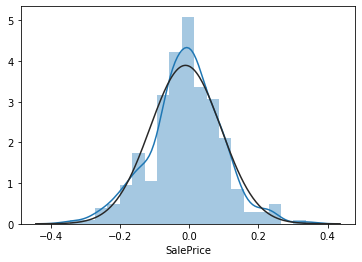

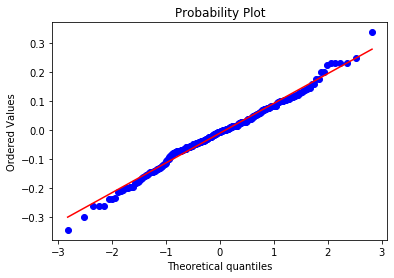

In [5]:
df_processed = data_process(test=False)
x_m = df_processed.drop(["SalePrice"], axis=1)
y_m = df_processed.loc[:,'SalePrice']
X_train, X_test, y_train, y_test = train_test_split(x_m, y_m, test_size=0.2, random_state=42)

ols = LinearRegression()
ols.fit(X_train, y_train)

error = ols.predict(X_test) - y_test
print('The mean of the errors is %.4f' %np.mean(error))
print('The standard deviation of the errors is %.4f' % np.std(error))
print("Skewness: %f" % error.skew())
print("Kurtosis: %f" % error.kurt())
sns.distplot(error, fit=norm);
fig = plt.figure()
res = stats.probplot(error, plot=plt)


High Kurtosis means there are outliers for the model which are hard to fit in the model 

In [ ]:
# Drop the outliers 
error.sort_values(ascending=False)

In [7]:
X= X_train
Y= y_train
index = np.where(np.logical_and(X > 0, X < 0.5))
sub_X = X[index]
sub_Y = Y[index]

plt.figure(figsize=(9, 6))
plt.ylim(0.7, 1.7)
plt.xlim(-0.1, 1.1)
plt.scatter(sub_X, sub_Y, alpha=0.3, color='green')
plt.scatter(X, Y, alpha=0.05, color='yellow')
plt.plot(X, beta_0 + beta_1 * X)

TypeError: '(array([], dtype=int64), array([], dtype=int64))' is an invalid key

**Constant Variance and Independent Errors**

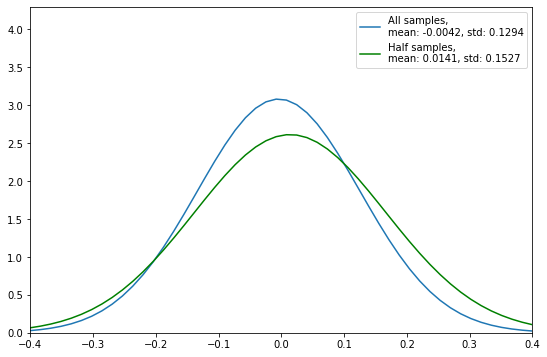

In [27]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


sub_error = error.sample(frac=0.5)

plt.figure(figsize=(9, 6))
plt.xlim(-0.4, 0.4)
plt.ylim(0, 4.3)

my_norm = stats.norm(np.mean(error), np.std(error)).pdf
label = 'All samples,\nmean: %.4f, std: %.4f' % (np.mean(error), np.std(error))
plt.plot(np.linspace(-0.4, 0.4), my_norm(np.linspace(-0.4, 0.4)), label=label)

my_norm = stats.norm(np.mean(sub_error), np.std(sub_error)).pdf
label = 'Half samples,\nmean: %.4f, std: %.4f' % (np.mean(sub_error), np.std(sub_error))
plt.plot(np.linspace(-0.4, 0.4), my_norm(np.linspace(-0.4, 0.4)), color='green', label=label)

plt.legend()
plt.show()